# CS 189 HW 6: Neural Networks
**Note:** before starting this notebook, please make a copy of it, otherwise your changes will not persist.

This part of the assignment is designed to get you familiar with how engineerings in the real world train neural network systems. It isn't designed to be difficult. In fact, everything you need to complete the assignment is available directly on the pytorch website [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). This note book will have the following components:

1. Understanding the basics of Pytorch (no deliverables)
2. Training a simple neural network on MNIST (Deliverable = training graphs)
3. Train a model on CIFAR-10 for Kaggle (Deliverable = kaggle submission and explanation of methods)

The last part of this notebook is left open for you to explore as many techniques as you want to do as well as possible on the dataset.

You will also get practice being an ML engineer by reading documentation and using it to implement models. The first section of this notebook will cover an outline of what you need to know -- we are confident that you can find the rest on your own.

Note that like all other assignments, you are free to use this notebook or not. You just need to complete the deliverables and turn in your code. If you want to run everything outside of the notebook, make sure to appropriately install pytorch to download the datasets and copy out the code for kaggle submission. If you don't want to use pytorch and instead want to use Tensorflow, feel free, but you may still need to install pytorch to download the datasets. That said, we will recommend pytorch over tensorflow since the latter has a somewhat steep learning curve and the former is more accessible to beginners.


In [24]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
import tqdm

# 1. Understanding Pytorch

Pytorch is based on the "autograd" paradigm. Essentially, you perform operations on multi-dimensional arrays like in numpy, except pytorch will automatically handle gradient tracking. In this section you will understand how to use pytorch.

This section should help you understand the full pipeline of creating and training a model in pytorch. Feel free to re-use code from this section in the assigned tasks.

Content in this section closely follows this pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/intro.html

## Tensors

Tensors can be created from numpy data or by using pytorch directly.

In [10]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)

shape = (2,3,)
rand_tensor = torch.rand(shape)
np_rand_array = rand_tensor.numpy()

print(f"Tensor from np: \n {x_np} \n")
print(f"Rand Tensor: \n {rand_tensor} \n")
print(f"Rand Numpy Array: \n {np_rand_array} \n")

Tensor from np: 
 tensor([[1, 2],
        [3, 4]]) 

Rand Tensor: 
 tensor([[0.6314, 0.4146, 0.0799],
        [0.1025, 0.7797, 0.2927]]) 

Rand Numpy Array: 
 [[0.63136035 0.41459703 0.0799427 ]
 [0.10253042 0.7797498  0.29266316]] 



They also support slicing and math operations very similar to numpy. See the examples below:

In [11]:
# Slicing
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])

# Matrix Operations
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

# Getting a single item
scalar = torch.sum(y1) # sums all elements
item = scalar.item()
print("Sum as a tensor:", scalar, ", Sum as an item:", item)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Sum as a tensor: tensor(64.) , Sum as an item: 64.0


## Autograd
This small section shows you how pytorch computes gradients. When we create tenors, we can set `requires_grad` to be true to indicate that we are using gradients. For most of the work that you actually do, you will use the `nn` package, which automatically sets all parameter tensors to have `requires_grad=True`.

In [12]:
# Below is an example of computing the gradient for a single data point in logistic regression using pytorch's autograd.

x = torch.ones(5)  # input tensor
y = torch.zeros(1) # label
w = torch.randn(5, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
pred = torch.sigmoid(torch.matmul(x, w) + b)
loss = torch.nn.functional.binary_cross_entropy(pred, y)
loss.backward() # Computers gradients
print("W gradient:", w.grad)
print("b gradient:", b.grad)

# when we want to actually take an update step, we can use optimizers:
optimizer = torch.optim.SGD([w, b], lr=0.1)
print("Weight before", w)
optimizer.step() # use the computed gradients to update
# Print updated weights
print("Updated weight", w)

# Performing operations with gradients enabled is slow...
# You can disable gradient computation using the following enclosure:
with torch.no_grad():
    # Perform operations without gradients
    ...

W gradient: tensor([[0.6486],
        [0.6486],
        [0.6486],
        [0.6486],
        [0.6486]])
b gradient: tensor([0.6486])
Weight before tensor([[-1.9907],
        [ 0.2739],
        [ 0.4545],
        [ 1.0306],
        [ 0.6856]], requires_grad=True)
Updated weight tensor([[-2.0556],
        [ 0.2090],
        [ 0.3897],
        [ 0.9658],
        [ 0.6207]], requires_grad=True)


## Devices
Pytorch supports accelerating computation using GPUs which are available on google colab. To use a GPU on google colab, go to runtime -> change runtime type -> select GPU.

Note that there is some level of strategy for knowing when to use which runtime type. Colab will kick users off of GPU for a certain period of time if you use it too much. Thus, its best to run simple models and prototype to get everything working on CPU, then switch the instance type over to GPU for training runs and parameter tuning.

Its best practice to make sure your code works on any device (GPU or CPU) for pytorch, but note that numpy operations can only run on the CPU. Here is a standard flow for using GPU acceleration:

In [13]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# Next create your tensors
tensor = torch.zeros(4, 4, requires_grad=True)
# Move the tensor to the device you want to use
tensor = tensor.to(device)

# Perform whatever operations you want.... (often this will involve gradients)
# These operations will be accelerated by GPU.
tensor = 10*(tensor + 1)

# bring the tensor back to CPU, first detaching it from any gradient computations
tensor = tensor.detach().cpu()

tensor_np = tensor.numpy() # Convert to numpy if you want to perform numpy operations.

Using device cuda


## The NN Package
Pytorch implements composable blocks in `Module` classes. All layers and modules in pytorch inherit from `nn.Module`. When you make a module you need to implement two functions: `__init__(self, *args, **kwargs)` and `foward(self, *args, **kwargs)`. Modules also have some nice helper functions, namely `parameters` which will recursively return all of the parameters. Here is an example of a logistic regression model:

In [14]:
class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.layer = nn.Linear(in_dim, 1) # This is a linear layer, it computes Xw + b

  def forward(self, x):
    return torch.sigmoid(self.layer(x)).squeeze(-1)

perceptron = Perceptron(10)
perceptron = perceptron.to(device) # Move all the perceptron's tensors to the device
print("Parameters", list(perceptron.parameters()))

Parameters [Parameter containing:
tensor([[-0.0038,  0.0869,  0.2373, -0.2495,  0.2636,  0.0494, -0.0509, -0.1515,
          0.2410, -0.2244]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.1170], device='cuda:0', requires_grad=True)]


## Datasets

Pytorch has nice interfaces for using datasets. Suppose we create a logistic regression dataset as follows:

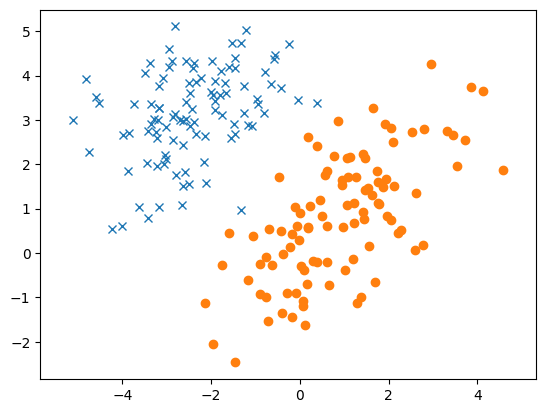

In [15]:
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
train_X = np.concatenate((c1_X, c2_X))
train_y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(train_X.shape[0])
train_X = train_X[permutation, :]
train_y = train_y[permutation]
# Plot the data
plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

We can then create a pytorch dataset object as follows. Often times, the default pytorch datasets will create these objects for you. Then, we can apply dataloaders to iterate over the dataset in batches.

In [16]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
# We can create a dataloader that iterates over the dataset in batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
for x, y in dataloader:
    print("Batch x:", x)
    print("Batch y:", y)
    break

# Clean up the dataloader as we make a new one later
del dataloader

Batch x: tensor([[-1.9685, -2.0459],
        [-1.4652,  4.4038],
        [-3.2021,  3.0058],
        [-2.5598,  3.0124],
        [ 1.9270,  2.9014],
        [-1.7861,  4.0981],
        [-3.4421,  2.0271],
        [-3.4193,  0.7825],
        [ 1.7318,  1.8485],
        [-2.6408,  2.4356]], dtype=torch.float64)
Batch y: tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0.], dtype=torch.float64)


## Training Loop Example
Here is an example of training a full logistic regression model in pytorch. Note the extensive use of modules -- modules can be used for storing networks, computation steps etc.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 10
learning_rate = 0.01

num_features = dataset[0][0].shape[0]
model = Perceptron(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm.notebook.tqdm(dataloader, unit="batch"):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

# We can run predictions on the data to determine the final accuracy.
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.float().to(device)
        pred = model(x)
        num_correct += torch.sum(torch.round(pred) == y).item()
    print("Final Accuracy:", num_correct / len(dataset))
    model.train() # Put model back in train mode

Using device cuda


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.6126908481121063


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.5522928982973099


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.509153401851654


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.4755027651786804


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.4488103985786438


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.42684453129768374


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.4080224961042404


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.3919648237526417


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.3777616560459137


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.36526969224214556
Final Accuracy: 0.81


# Task 1: MLP For FashionMNIST
Earlier in this course you trained SVMs and GDA models on MNIST. Now you will train a multi-layer perceptron model on an MNIST-like dataset. Your deliverables are as follows:

1. Code for training an MLP on MNIST (can be in code appendix, tagged in your submission).
2. A plot of the training loss and validation loss for each epoch of training after trainnig for at least 8 epochs.
3. A plot of the training and validation accuracy, showing that it is at least 82% for validation by the end of training.

Below we will create the training and validation datasets for you, and provide a very basic skeleton of the code. Please leverage the example training loop from above.

Some pytorch components you should definitely use:
1. `nn.Linear`
2. Some activation function like `nn.ReLU`
3. `nn.CrossEntropyLoss`: if you choose to use `nn.CrossEntropyLoss` or `F.cross_entropy`, DO NOT add an explicit softmax layer in your neural network. PyTorch devs found it more numerically stable to combine softmax and cross entropy loss into a single module and if you explicitly attach a softmax layer at the end of your model, you would unintentionally be applying it twice, which can degrade performance.

Here are challenges you will need to overcome:
1. The data is default configured in image form i.e. (1 x 28 x 28), versus one feature vector. You will need to reshape it somewhere to feed it in as vector to the MLP. There are many ways of doing this.
2. You need to write code for plotting.
3. You need to find appropriate hyper-parameters to achieve good accuracy.

Your underlying model must be fully connected or dense, and may not have convolutions etc., but you can use anything in torch.optim or any layers in torch.nn besides nn.Linear that do not have weights.

In [12]:
# Creating the datasets
import os
import warnings
from modulefinder import Module
import torchvision

SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

unprocessed_train_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
)
mean = unprocessed_train_data.data.float().mean() / 255
sd = unprocessed_train_data.data.float().std() / 255

train_transforms = torchvision.transforms.Compose([
                            torchvision.transforms.RandomRotation(5, fill=(0,)),
                            torchvision.transforms.RandomCrop(28, padding=2),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(mean=[mean], std=[sd])
                                      ])

test_transforms = torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(mean=[mean], std=[sd])
                                     ])
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transforms
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transforms
)


100%|██████████| 26421880/26421880 [00:02<00:00, 11967065.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202732.05it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3758358.11it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5492820.40it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



torch.Size([10000, 28, 28])

Before training a neural network, let's visualize our data first! Running the cell below will display the first 9 images in a 3 by 3 grid.

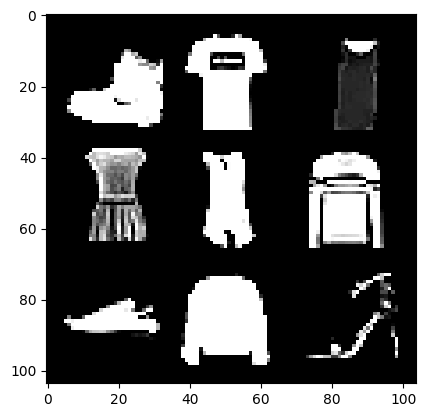

In [38]:
from matplotlib import pyplot as plt
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [19]:
import numpy as np
import torch.utils.data as data

train_data, val_data = data.random_split(training_data, [int(len(training_data)*0.9), int(len(training_data)*0.1)])

In [40]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [41]:
import copy
val_data = copy.deepcopy(val_data)
val_data.dataset.transform = test_transforms # to make sure the validation data stays the distribution as in training set

In [42]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader(val_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

# Build Model Architecture

In [43]:
import torch.nn.functional as func


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, 250)
        self.hidden_layer = nn.Linear(250, 100)
        self.output_layer = nn.Linear(100, output_dim)

    def forward(self, x):


        batch_size = x.shape[0]

        x = x.view(batch_size, -1)


        h_1 = func.relu(self.input_layer(x))


        h_2 = func.relu(self.hidden_layer(h_1))


        y_pred = self.output_layer(h_2)


        return y_pred, h_2

In [44]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [45]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
CEL = nn.CrossEntropyLoss().to(device)

In [46]:
def calculate_accuracy(y_pred, y):
    first_pred = y_pred.argmax(1, keepdim=True)
    correct = first_pred.eq(y.view_as(first_pred)).sum()
    accuracy = correct.float() / y.shape[0]
    return accuracy



In [47]:
from tqdm.notebook import trange, tqdm
def train(model, iterator, optimizer, CEL, device):

    epoch_loss = 0
    epoch_accuracy = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = CEL(y_pred, y)

        accuracy = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)


def evaluate(model, iterator, CEL, device):

    epoch_loss = 0
    epoch_accuracy = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = CEL(y_pred, y)

            accuracy = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.666 | Train Acc: 74.74%
	 Val. Loss: 0.479 |  Val. Acc: 81.90%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.522 | Train Acc: 80.32%
	 Val. Loss: 0.429 |  Val. Acc: 83.72%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.477 | Train Acc: 82.22%
	 Val. Loss: 0.403 |  Val. Acc: 84.79%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.448 | Train Acc: 83.33%
	 Val. Loss: 0.374 |  Val. Acc: 86.18%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.434 | Train Acc: 83.83%
	 Val. Loss: 0.374 |  Val. Acc: 85.91%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.420 | Train Acc: 84.27%
	 Val. Loss: 0.352 |  Val. Acc: 87.01%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.413 | Train Acc: 84.38%
	 Val. Loss: 0.347 |  Val. Acc: 86.88%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.402 | Train Acc: 84.88%
	 Val. Loss: 0.349 |  Val. Acc: 87.31%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.393 | Train Acc: 85.53%
	 Val. Loss: 0.362 |  Val. Acc: 86.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

	Train Loss: 0.386 | Train Acc: 85.55%
	 Val. Loss: 0.337 |  Val. Acc: 87.40%


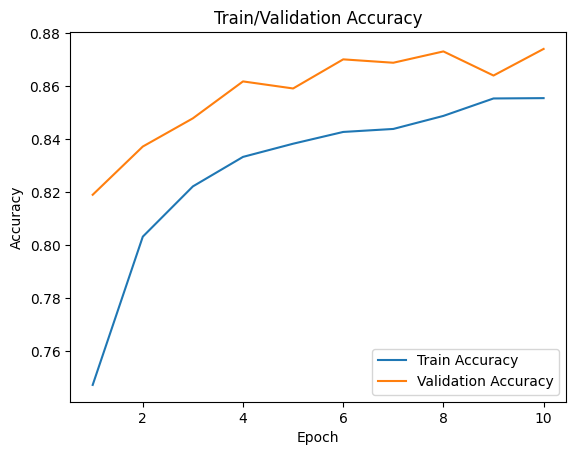

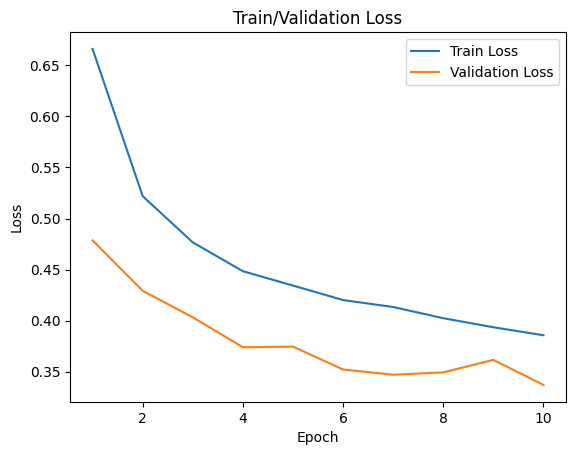

In [48]:

EPOCHS = 10

best_val_loss = float('inf')

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in trange(EPOCHS):

    train_loss, train_accuracy = train(model, train_iterator, optimizer, CEL, device)
    val_loss, val_accuracy = evaluate(model, val_iterator, CEL, device)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_accuracy*100:.2f}%')


plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy')
plt.legend()
plt.show()

plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()
plt.show()

In [49]:
train_accuracy

0.8554564080249641